In [1]:
#start all integration scripts like this

import sys
sys.path.append('/home/pwahle/Organoid-Image-Analysis/scripts/modules')
#alternative to sys.append('...'):
#set PYTHONPATH; in ~/.bashrc add below last line: export PYTHONPATH=/home/<your username>/Organoid-Image-Analysis/scripts/modules
#this option doesn't work for me.

import yaml 
import Paths #all kinds of paths, image paths are functions with default variables plate = "plate6", cycle = 'cycle1'; aligned_images_path has no variable 'cylce'. 


#load parameters
with open("../../params.yml", 'r') as ymlfile: 
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
globals().update(cfg) # optional, 'activates' all parameters

In [11]:
from skimage import io
from matplotlib import pyplot as plt
from skimage import filters
import os
import cv2 as cv
import numpy as np
import matplotlib
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
import copy
from skimage.feature import blob_log
import toolz
import imp
import imageio
import Example



folder = Paths.aligned_images_path() + "/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD"



membrane = io.imread(folder + "/cycle1_aligned.tif")[...,1].astype('uint16')
dapi = io.imread(folder + "/cycle1_aligned.tif")[...,2].astype('uint16')

segmented_normal = io.imread(folder + "/dapi_mask.tif")
segmented_log = io.imread(folder + "/dapi_mask_log_membrane.tif")

subtracted = Example.subtract_membrane(dapi, membrane)

In [33]:
import pandas as pd  
from skimage.measure import regionprops, regionprops_table


list = [segmented_normal,segmented_log]
rprops_table = []
data = []
for i in np.arange(0,2):
    rprops_table.append(regionprops_table(list[i], intensity_image=subtracted, properties=('label', 'area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'filled_area', 'extent',
                                                                       'major_axis_length', 'minor_axis_length', 'moments_central', 'moments_hu', 'perimeter','orientation',
                                                                       'solidity', 'weighted_moments_central', 'weighted_moments_hu', 'inertia_tensor', 'inertia_tensor_eigvals', 'moments', 'max_intensity', 'mean_intensity', 'min_intensity')))

    data.append(pd.DataFrame(rprops_table[i]))

    data[i] = data[i].set_index("label")
    
    



In [49]:
single_nuclei = []
for i in np.arange(0,2):

    single_nuclei.append(copy.deepcopy(list[i]))

    cluster_labels = data[i].index.values[(data[i]['minor_axis_length'] <= 50) & (data[i]['major_axis_length'] <= 60)]

    single_nuclei[i][np.invert(np.isin(single_nuclei[i], cluster_labels))] = 0

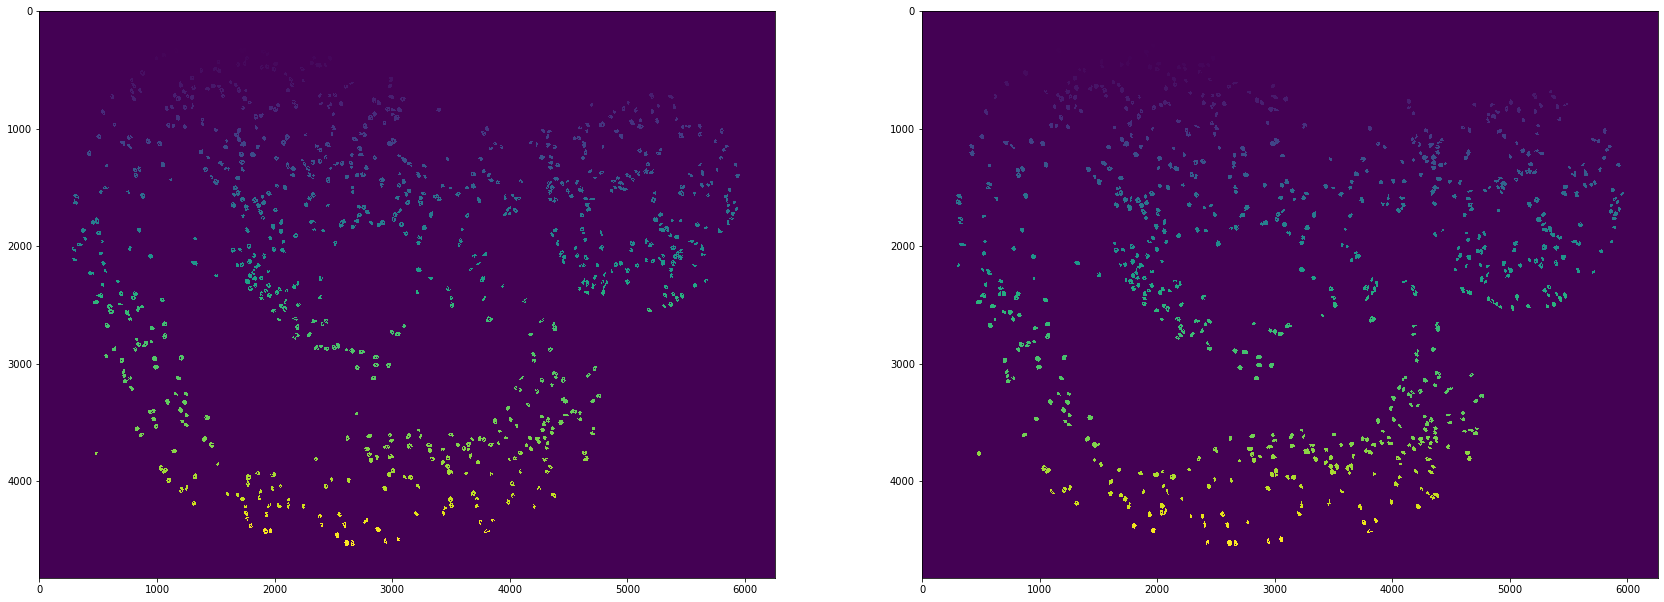

In [52]:
fig, ax = plt.subplots(1,2,figsize = (29,29))
ax[0].imshow(single_nuclei[0])
ax[1].imshow(single_nuclei[1])
plt.show()

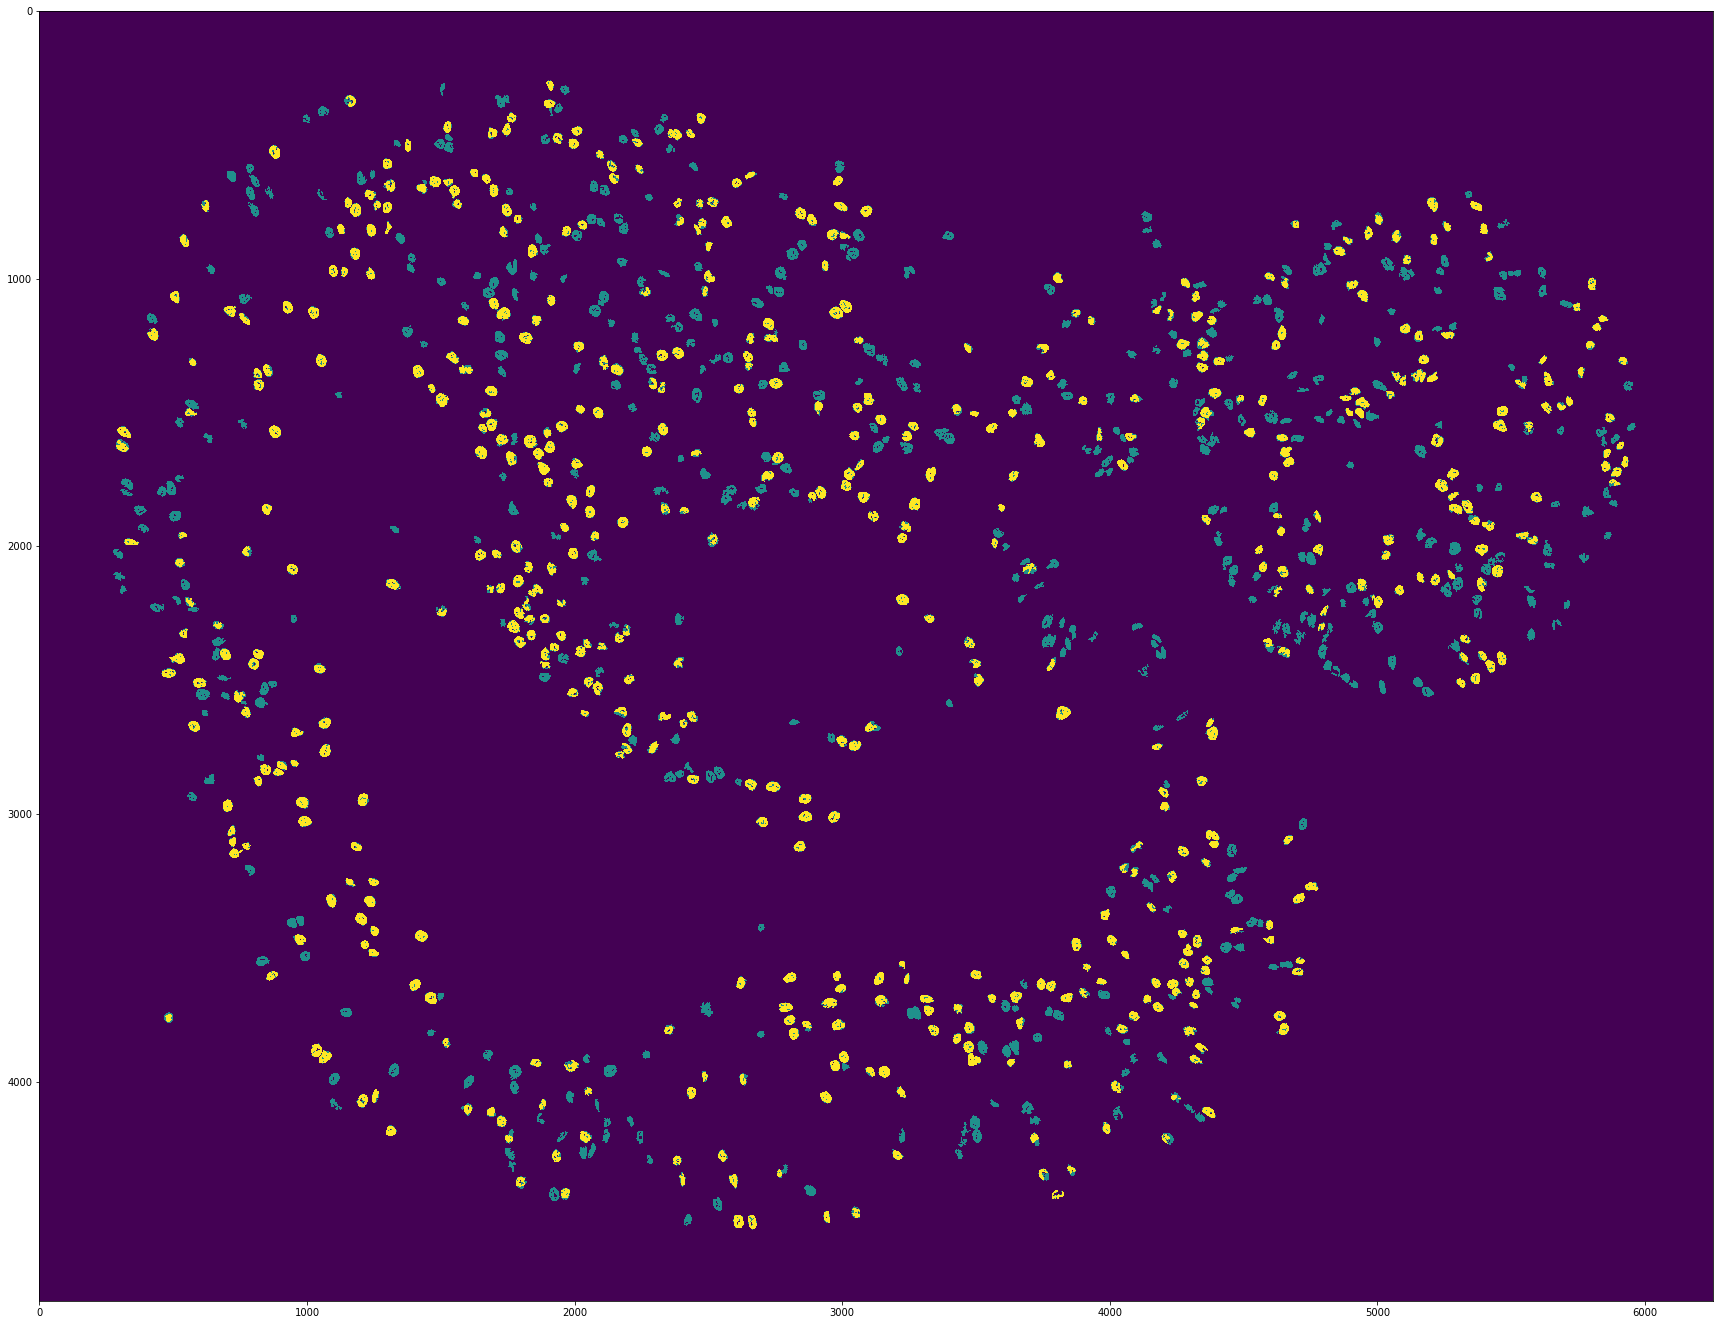

In [57]:
for i in np.arange(0,2):
    single_nuclei[i] = np.where(single_nuclei[i]>0.5, 1000, 0)


union = single_nuclei[0] + single_nuclei[1]
#sub = sub[1000:5000,1000:5000]
fig = plt.figure(figsize = (30,30))
plt.imshow(union)
plt.show()

In [275]:
from skimage.measure import label
union = np.where(union>0.5, 2000, 0)

test = label(union, connectivity = 1)
tmp = copy.deepcopy(test)
values = np.random.randint(100, size=np.unique(test).size) * 100 + 1000

for i in np.unique(tmp)[1:]:
    test[test == i] = values[np.where(np.unique(tmp) == i)][0]

KeyboardInterrupt: 

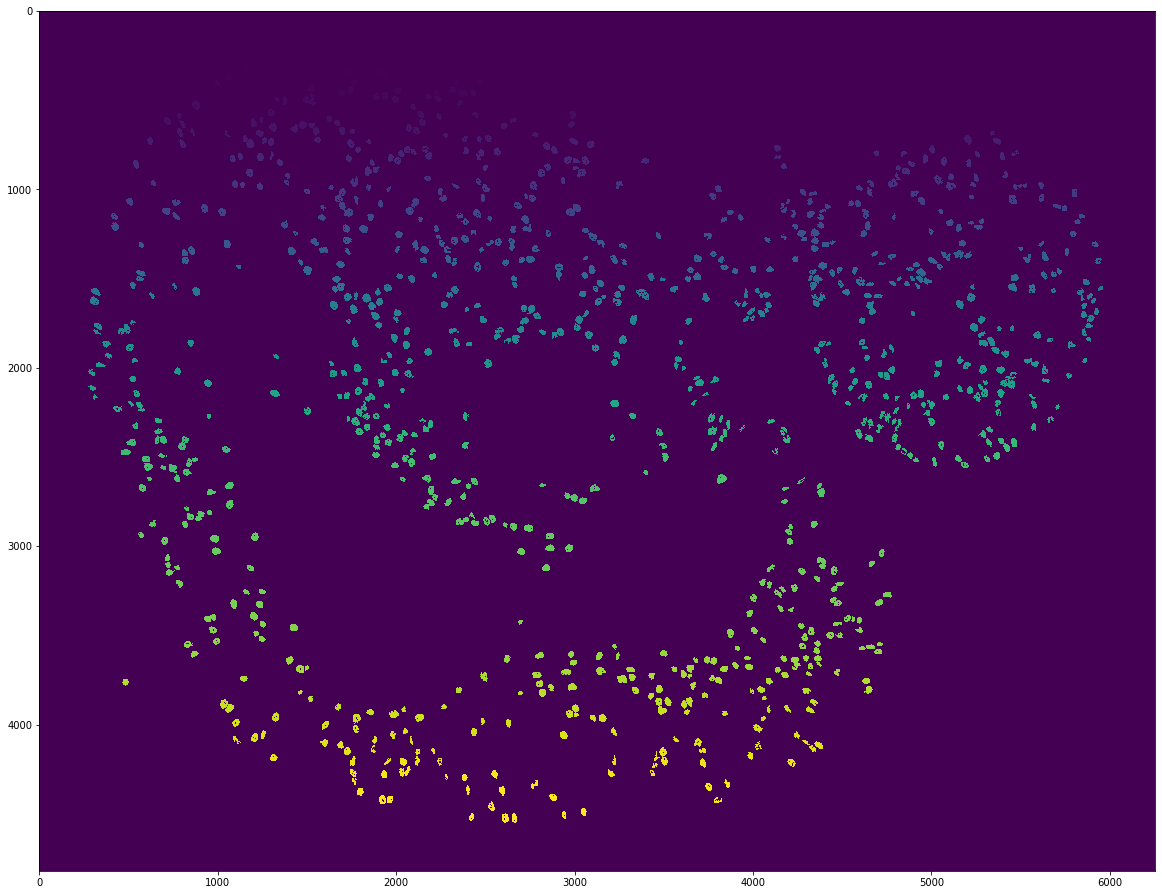

In [277]:
fig = plt.figure(figsize = (20,20))
plt.imshow(test)
plt.show()

In [278]:
import generic_funcs
imp.reload(generic_funcs)

<module 'generic_funcs' from '/home/pwahle/Organoid-Image-Analysis/scripts/modules/generic_funcs.py'>

In [315]:
test = label(union, connectivity = 1)

rprops_df = generic_funcs.get_rprops_table(labels = test, intensity_image = subtracted)

In [316]:
imp.reload(generic_funcs)

single, clusters = generic_funcs.get_nuclei_from_label_mask(label_mask = test, rprops_table = rprops_df)

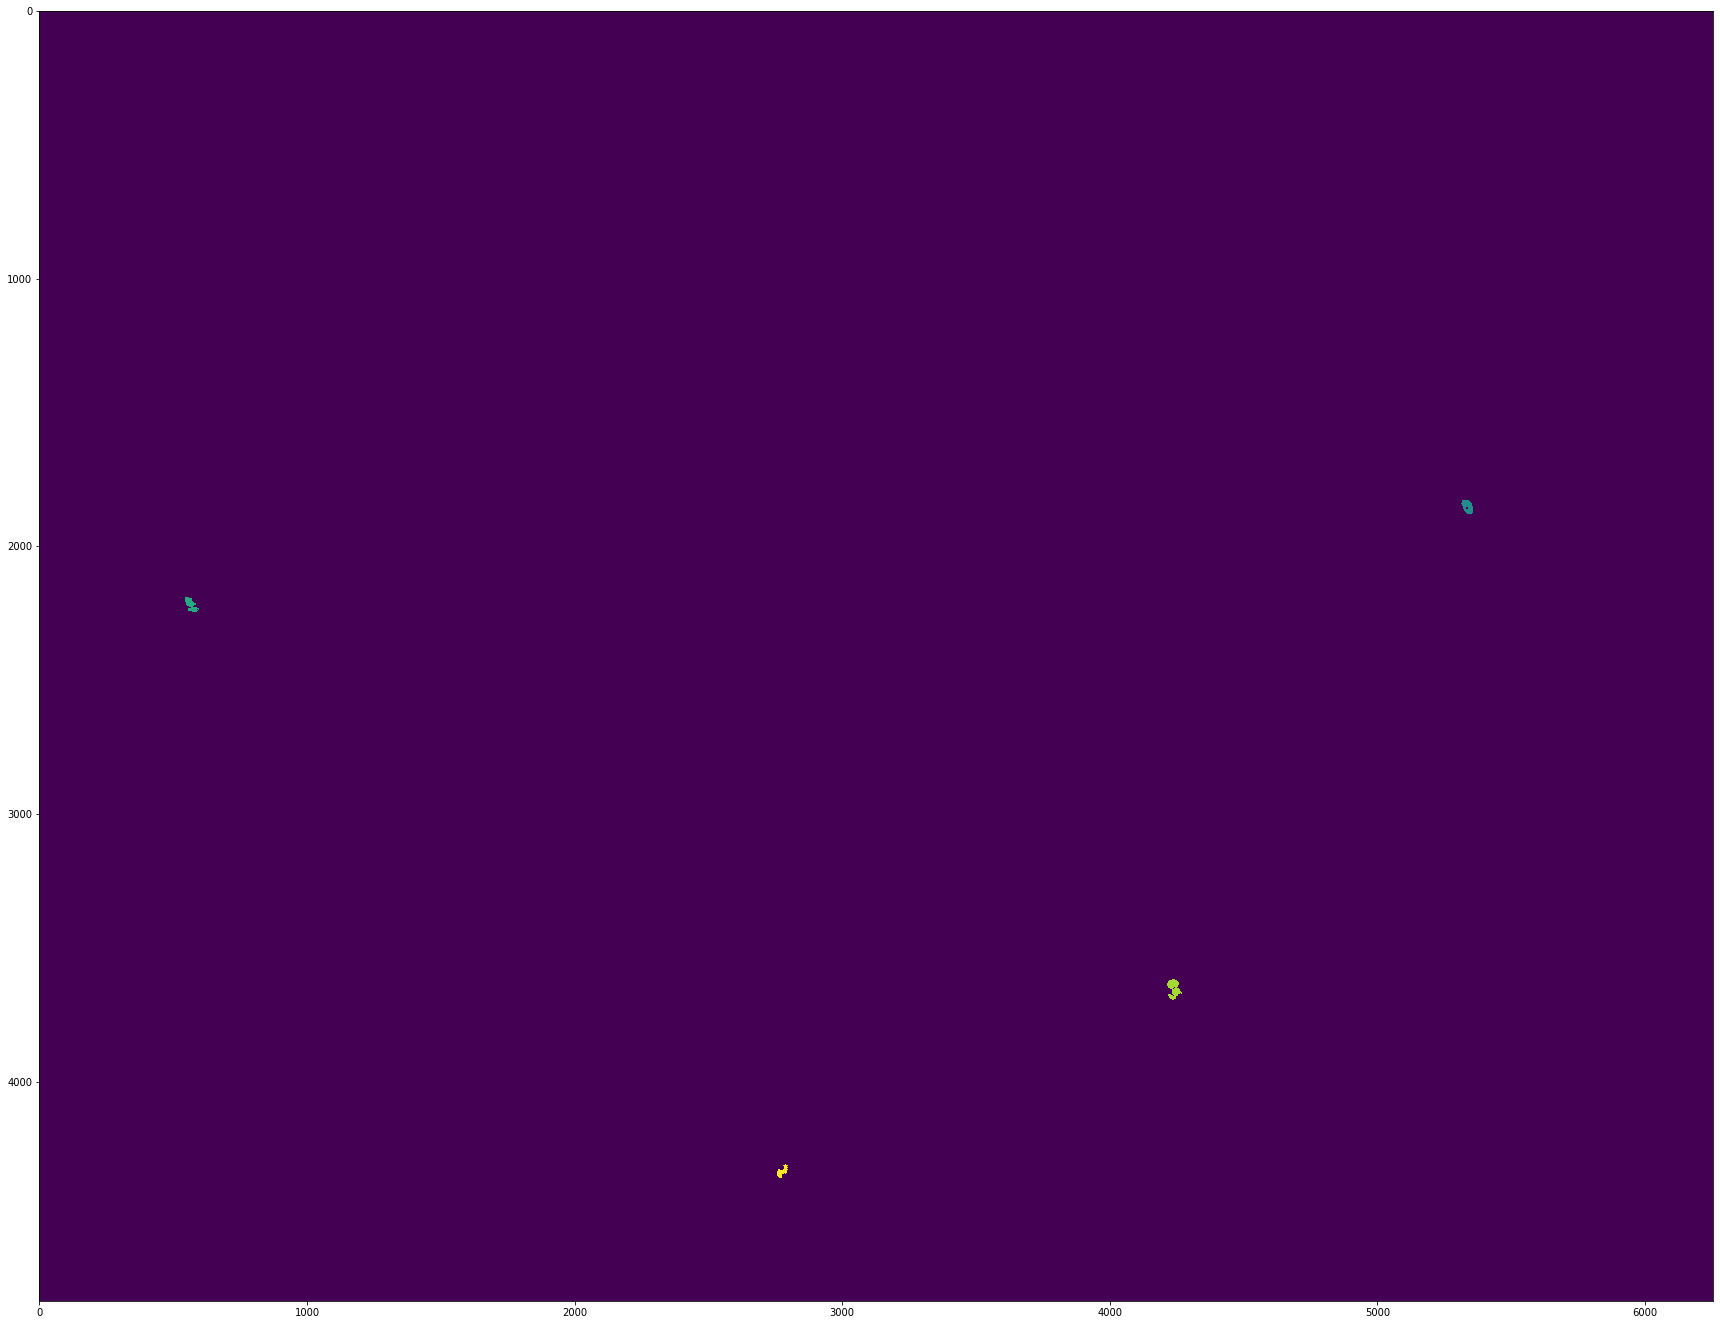

In [317]:
fig = plt.figure(figsize = (30,30))
plt.imshow(clusters)

In [318]:
np.unique(clusters)[1]

object_bboxes = rprops_df.iloc[np.unique(clusters)[1:]-1][['bbox-0', 'bbox-1', 'bbox-2', 'bbox-3']].to_numpy()

#bbox = object_bboxes.iloc[0].to_numpy()

box1 = single[bbox[0]:bbox[2],bbox[1]:bbox[3]]



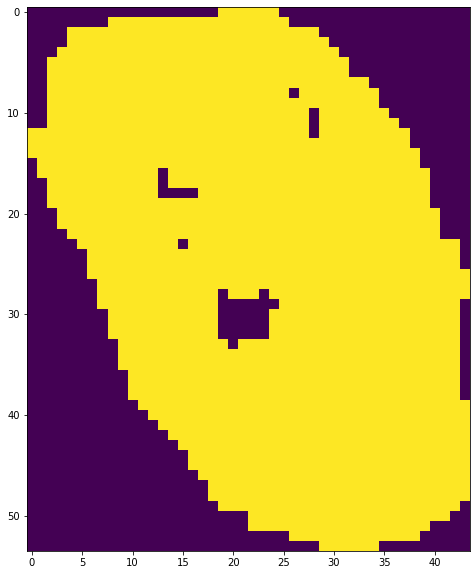

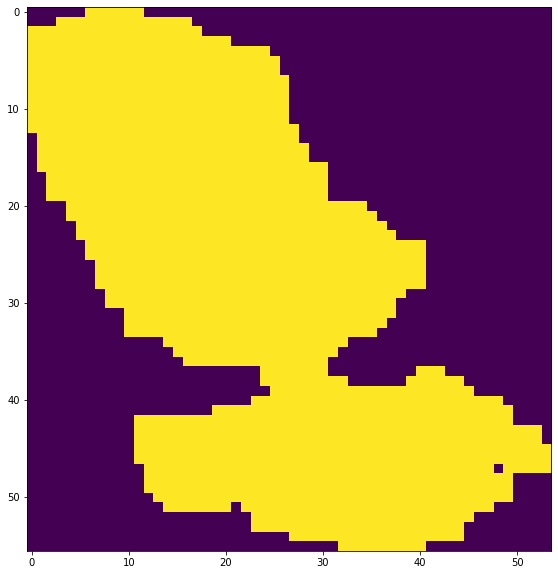

<Figure size 432x288 with 0 Axes>

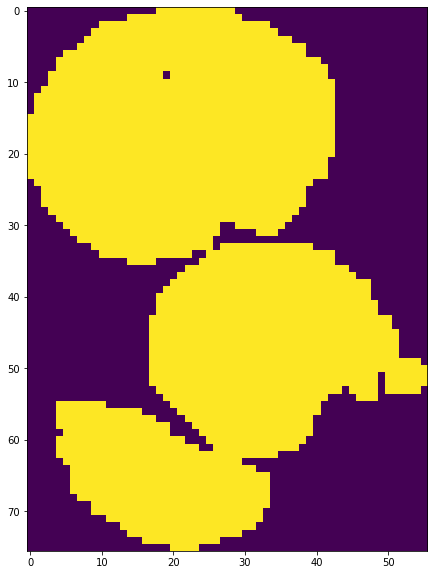

<Figure size 432x288 with 0 Axes>

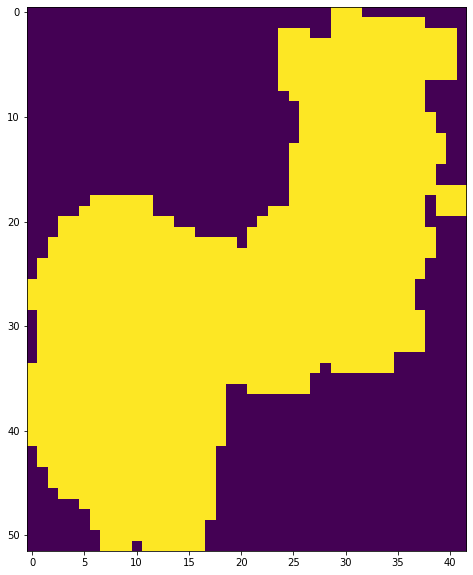

<Figure size 432x288 with 0 Axes>

In [319]:

for i in np.arange(object_bboxes.shape[0]):
    fig = plt.figure(figsize = (10,10))
    plt.imshow(clusters[object_bboxes[i][0]:object_bboxes[i][2],object_bboxes[i][1]:object_bboxes[i][3]])
    plt.figure(i+1)
    plt.show()
